In [2]:
import numpy as np 
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from aare import ClusterFinder, Interpolator, ClusterFile
from aare import calculate_eta2, calculate_eta3, calculate_cross_eta3
import boost_histogram as bh
from aare._aare import Cluster2x2d, ClusterVector_Cluster2x2d, Cluster3x3d, ClusterVector_Cluster3x3d
import pickle
import os
from glob import glob

from test_Interpolation import create_photon_hit_with_gaussian_distribution, create_2x2cluster_from_frame, create_3x3cluster_from_frame, calculate_eta_distribution, photon_hit_in_euclidean_space

# 3x3 Cross

### 3x3 Cross Eta Histogram

In [ ]:
def calculate_eta_distribution(sampleFileList, calculate_eta):
    nbins = 101
    eta_distribution = bh.Histogram(
    bh.axis.Regular(nbins, -0.5, 0.5), 
    bh.axis.Regular(nbins, -0.5, 0.5), bh.axis.Regular(1, 0, 20000)) #-1.2, 1.2

    for sampleFile in sampleFileList:
        samples = np.load(sampleFile)['samples'][:, 1:-1, 1:-1]

        samples = samples.reshape(samples.shape[0], 9)

        eta = np.apply_along_axis(calculate_eta, 1, samples)

        eta_distribution.fill(eta[:,0], eta[:,1], eta[:,2]) #, eta[2])

    return eta_distribution


def plot_eta_distribution(eta_distribution):
    plt.imshow(
    np.log1p(eta_distribution[:, :, 0].view() + 1).transpose(),   
    origin='lower',   
    extent=[eta_distribution.axes[0].edges[0], eta_distribution.axes[0].edges[-1], eta_distribution.axes[1].edges[0], eta_distribution.axes[1].edges[-1]],               
    aspect='auto')
    plt.colorbar()
    plt.xlabel('eta_x')
    plt.ylabel('eta_y')
    plt.show()

def plot_distribution(eta_distribution):
    plt.imshow(
    np.log1p(eta_distribution[:, :].view() + 1).transpose(),   
    origin='lower',   
    extent=[eta_distribution.axes[0].edges[0], eta_distribution.axes[0].edges[-1], eta_distribution.axes[1].edges[0], eta_distribution.axes[1].edges[-1]],               
    aspect='auto')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()


In [4]:
my_mount = '/mnt/sls_det_storage/'
#my_mount = "/home/mazzol_a/my_test_mount/"
sampleFileList = glob(os.path.join(my_mount,'moench_data/MLXID/Samples/Simulation/Moench040/15keV_Moench040_150V_*.npz'))


print(sampleFileList)

['/mnt/sls_det_storage/moench_data/MLXID/Samples/Simulation/Moench040/15keV_Moench040_150V_10.npz', '/mnt/sls_det_storage/moench_data/MLXID/Samples/Simulation/Moench040/15keV_Moench040_150V_4.npz', '/mnt/sls_det_storage/moench_data/MLXID/Samples/Simulation/Moench040/15keV_Moench040_150V_3.npz', '/mnt/sls_det_storage/moench_data/MLXID/Samples/Simulation/Moench040/15keV_Moench040_150V_11.npz', '/mnt/sls_det_storage/moench_data/MLXID/Samples/Simulation/Moench040/15keV_Moench040_150V_2.npz', '/mnt/sls_det_storage/moench_data/MLXID/Samples/Simulation/Moench040/15keV_Moench040_150V_5.npz', '/mnt/sls_det_storage/moench_data/MLXID/Samples/Simulation/Moench040/15keV_Moench040_150V_8.npz', '/mnt/sls_det_storage/moench_data/MLXID/Samples/Simulation/Moench040/15keV_Moench040_150V_6.npz', '/mnt/sls_det_storage/moench_data/MLXID/Samples/Simulation/Moench040/15keV_Moench040_150V_1.npz', '/mnt/sls_det_storage/moench_data/MLXID/Samples/Simulation/Moench040/15keV_Moench040_150V_15.npz', '/mnt/sls_det_st

(625000, 3, 3)
(625000, 9)
(625000, 3, 3)
(625000, 9)
(625000, 3, 3)
(625000, 9)
(625000, 3, 3)
(625000, 9)
(625000, 3, 3)
(625000, 9)
(625000, 3, 3)
(625000, 9)
(625000, 3, 3)
(625000, 9)
(625000, 3, 3)
(625000, 9)
(625000, 3, 3)
(625000, 9)
(625000, 3, 3)
(625000, 9)
(625000, 3, 3)
(625000, 9)
(625000, 3, 3)
(625000, 9)
(625000, 3, 3)
(625000, 9)
(625000, 3, 3)
(625000, 9)
(625000, 3, 3)
(625000, 9)
(625000, 3, 3)
(625000, 9)
93189.0
103.0


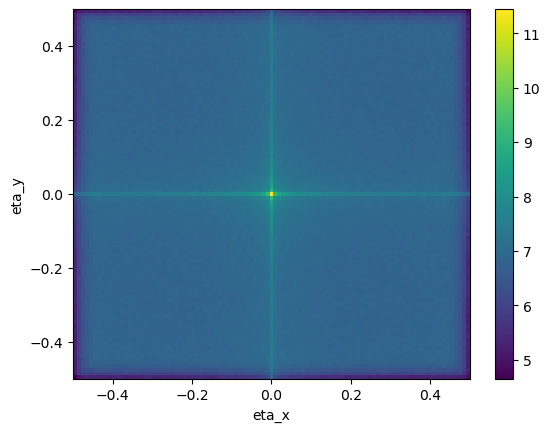

In [4]:
def calculate_eta3x3(sample): 
    cluster = Cluster3x3d(1,1, sample.flatten()) 
    return calculate_eta3(cluster)

eta_distribution = calculate_eta_distribution(sampleFileList, calculate_eta3x3)

print(eta_distribution.view().max())
print(eta_distribution.view().min())

plot_eta_distribution(eta_distribution)

In [5]:
test_data_path = os.getenv("AARE_TEST_DATA") + "/eta_distributions"
filename = test_data_path + "/eta_distribution_2x2cluster_simulated.pkl"
with open(filename, "wb") as f:
    pickle.dump(eta_distribution, f)

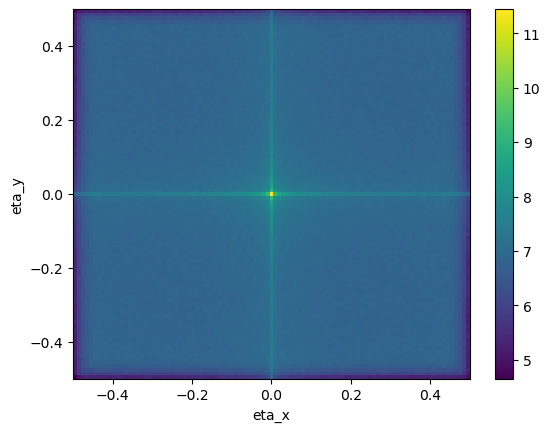

In [5]:
filename = os.getenv("AARE_TEST_DATA") + "/eta_distributions/eta_distribution_2x2cluster_simulated.pkl"
with open(filename, "rb") as f:
    eta_distribution = pickle.load(f)

plot_eta_distribution(eta_distribution)

In [ ]:
def calculate_eta2(sample): 
    cluster = Cluster3x3d(1,1, sample.flatten()) 
    return calculate_eta2(cluster)

eta_distribution_2x2 = calculate_eta_distribution(sampleFileList, calculate_eta2)

print(eta_distribution_2x2.view().max())
print(eta_distribution_2x2.view().min())

plot_eta_distribution(eta_distribution_2x2)

## Interpolate

In [ ]:
cluster_vec = ClusterVector_Cluster3x3d();
for sampleFile in sampleFileList:
    samples = np.load(sampleFile)['samples'][:, 1:-1, 1:-1]

    samples = samples.reshape(samples.shape[0], 9)

    np.apply_along_axis(lambda sample : cluster_vec.push_back(Cluster3x3d(1,1,sample)), 1, samples)


print(cluster_vec.size)

cluster_file = os.getenv("AARE_TEST_DATA") + "/eta_distributions/clusters.clust"
clusterfile = ClusterFile(cluster_file, dtype=np.float64, mode="w")
clusterfile.write_frame(cluster_vec)

(625000, 3, 3)
(625000, 3, 3)
(625000, 3, 3)
(625000, 3, 3)
(625000, 3, 3)
(625000, 3, 3)
(625000, 3, 3)
(625000, 3, 3)
(625000, 3, 3)
(625000, 3, 3)
(625000, 3, 3)
(625000, 3, 3)
(625000, 3, 3)
(625000, 3, 3)
(625000, 3, 3)
(625000, 3, 3)
10000000


In [9]:
cluster_file = os.getenv("AARE_TEST_DATA") + "/eta_distributions/clusters.clust"
clusterfile = ClusterFile(cluster_file, dtype=np.float64, mode="r")
cluster_vec = clusterfile.read_frame()

In [10]:
ground_truth = []
for sampleFile in sampleFileList:
    labels = np.load(sampleFile)['labels']
    ground_truth.append(labels[:,:3])

ground_truth = np.concatenate(ground_truth, axis=0)

ground_truth.shape

(10000000, 3)

2.0298220298220295
-477.2281720180495
2.0400977995110026
-0.828336646155001
(10000000,)


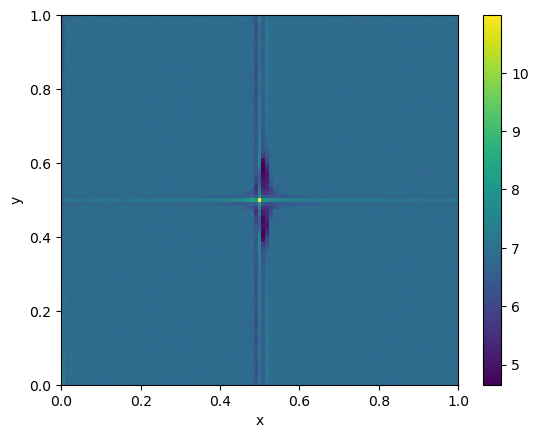

In [11]:
### rosenblatt 
#interpolator = Interpolator(eta_distribution, eta_distribution.axes[0].edges, eta_distribution.axes[1].edges, eta_distribution.axes[2].edges[:-1])


interpolator = Interpolator(eta_distribution.axes[0].edges, eta_distribution.axes[1].edges, eta_distribution.axes[2].edges[:-1])
interpolator.rosenblatttransform(eta_distribution.values())

interp_photons_rosenblatt = interpolator.interpolate_eta3x3(cluster_vec)

print(interp_photons_rosenblatt[:]["x"].max())
print(interp_photons_rosenblatt[:]["x"].min())
print(interp_photons_rosenblatt[:]["y"].max())
print(interp_photons_rosenblatt[:]["y"].min())

residuals_rosenblatt_x = interp_photons_rosenblatt[:]["x"] + 1 - ground_truth[:, 0]
residuals_rosenblatt_y = interp_photons_rosenblatt[:]["y"] + 1 - ground_truth[:, 1]

residuals_rosenblatt = np.sqrt(residuals_rosenblatt_x**2 + residuals_rosenblatt_y**2)

print(residuals_rosenblatt_x.shape)

nbins = 101
interp_data_distribution = bh.Histogram(
    bh.axis.Regular(nbins, 0, 1.0), 
    bh.axis.Regular(nbins, 0, 1.0))


#print(interp_photons_rosenblatt["x"])

interp_data_distribution.fill(interp_photons_rosenblatt["x"]-1, interp_photons_rosenblatt["y"]-1) 

plot_distribution(interp_data_distribution)

In [10]:
interpolator = Interpolator(eta_distribution_cross.axes[0].edges[:-1], eta_distribution_cross.axes[1].edges[:-1], eta_distribution_cross.axes[2].edges[:-1])

interpolator.rosenblatttransform(eta_distribution_cross.values())

interp_photons_rosenblatt_cross = interpolator.interpolate_cross_eta3x3(cluster_vec)

residuals_rosenblatt_cross_x = interp_photons_rosenblatt_cross[:]["x"] + 1 - ground_truth[:, 0]
residuals_rosenblatt_cross_y = interp_photons_rosenblatt_cross[:]["y"] + 1 - ground_truth[:, 1]

residuals_rosenblatt_cross = np.sqrt(residuals_rosenblatt_cross_x**2 + residuals_rosenblatt_cross_y**2)

2.0462962962962963
0.9935831815762848
2.0400977995110026
0.9940397711602722


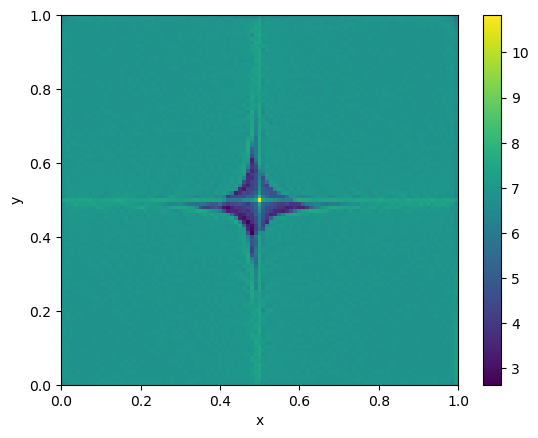

In [13]:
interpolator = Interpolator(eta_distribution, eta_distribution.axes[0].edges, eta_distribution.axes[1].edges, eta_distribution.axes[2].edges[:-1])

interp_photons_non_rosenblatt = interpolator.interpolate_eta3x3(cluster_vec)

residuals_eta3_x = interp_photons_non_rosenblatt[:]["x"] + 1 - ground_truth[:, 0]
residuals_eta3_y = interp_photons_non_rosenblatt[:]["y"] + 1 - ground_truth[:, 1]

residuals_eta3 = np.sqrt(residuals_eta3_x**2 + residuals_eta3_y**2)

print(interp_photons_non_rosenblatt["x"].max())
print(interp_photons_non_rosenblatt["x"].min())
print(interp_photons_non_rosenblatt["y"].max())
print(interp_photons_non_rosenblatt["y"].min())

nbins = 101
interp_data_distribution = bh.Histogram(
    bh.axis.Regular(nbins, 0, 1.0), 
    bh.axis.Regular(nbins, 0, 1.0))

interp_data_distribution.fill(interp_photons_non_rosenblatt["x"]-1, interp_photons_non_rosenblatt["y"]-1) 

plot_distribution(interp_data_distribution)

In [ ]:
interpolator = Interpolator(eta_distribution_2x2.axes[0].edges[:-1], eta_distribution_2x2.axes[1].edges[:-1], eta_distribution_2x2.axes[2].edges[:-1])

interpolator.rosenblatttransform(eta_distribution_2x2.values())

interp_photons_eta2x2 = interpolator.interpolate(cluster_vec)

residuals_eta2_x = interp_photons_eta2x2[:]["x"] + 1 - ground_truth[:, 0]
residuals_eta2_y = interp_photons_eta2x2[:]["y"] + 1 - ground_truth[:, 1]

residuals_eta2 = np.sqrt(residuals_eta2_x**2 + residuals_eta2_y**2)


### Error Handling: 

In [14]:
def plot_residuals(residuals_x, residuals_y, residuals): 
    
    plt.figure(figsize=(8, 5))

    
    plt.hist(residuals_x, bins=np.linspace(-0.5, 0.5, 100),
            alpha=0.4, label='Residual X', density=False)
    plt.hist(residuals_y, bins=np.linspace(-0.5, 0.5, 100),
            alpha=0.4, label='Residual Y', density=False)
    plt.hist(residuals, bins=np.linspace(-0.5, 0.5, 100),
            alpha=0.4, label='Residual', density=False)

    """ 
    plt.hist(residuals_x, bins=np.linspace(-0.5, 0.5, 100),
            histtype='step', linewidth=2, label='Residual X', density=True)
    plt.hist(residuals_y, bins=np.linspace(-0.5, 0.5, 100),
            histtype='step', linewidth=2, label='Residual Y', density=True)
    """

    plt.xlabel('Residual')
    plt.ylabel('Density')
    plt.title('Eta interpolation residuals')
    plt.legend()

    mean_x = np.mean(residuals_x)
    std_x = np.std(residuals_x)
    mean_y = np.mean(residuals_y)
    std_y = np.std(residuals_y)
    mean = np.mean(residuals)
    std = np.std(residuals)

    plt.text(0.05, 0.9,
            f'mean x: {mean_x:.3f}\nstd x: {std_x:.3f}\nmean y: {mean_y:.3f}\nstd y: {std_y:.3f}\nmean: {mean:.3f}\nstd: {std:.3f}',
            transform=plt.gca().transAxes,
            fontsize=12,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.show()

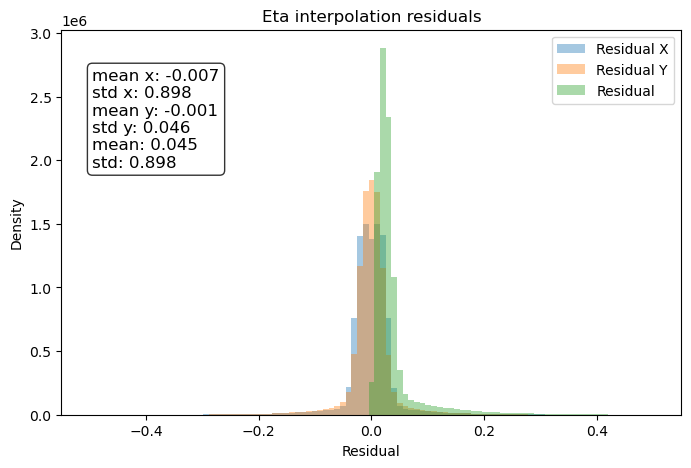

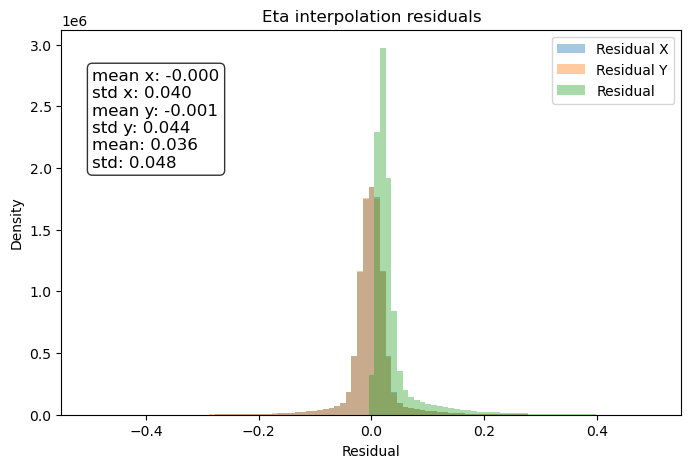

In [15]:
plot_residuals(residuals_rosenblatt_x, residuals_rosenblatt_y, residuals_rosenblatt)
#plot_residuals(residuals_rosenblatt_cross_x, residuals_rosenblatt_cross_y, residuals_rosenblatt_cross)
plot_residuals(residuals_eta3_x, residuals_eta3_y, residuals_eta3)
#plot_residuals(residuals_eta2_x, residuals_eta2_y, residuals_eta2)

In [14]:
def plot_residual_in_depth(residuals_x, residuals_y):
    ### residuls x categorized by z
    zBinWidth = 50 ### um
    zBinCenters = np.arange(0, 650, zBinWidth) + zBinWidth/2
    residul_x = []
    residul_y = []
    z = ground_truth[:,2]
    for zBin in range(0, 650, zBinWidth):
        zMask = (np.array(z) >= zBin) & (np.array(z) < zBin + zBinWidth)
        residuals_x_z = np.array(residuals_x)[zMask]
        residuals_y_z = np.array(residuals_y)[zMask]
        residul_x.append(np.std(residuals_x_z))
        residul_y.append(np.std(residuals_y_z))

    # plt.figure(figsize=(8, 8))
    plt.plot(zBinCenters, residul_x, label='residul x')
    plt.plot(zBinCenters, residul_y, label='residul y')
    ### set y limit
    plt.ylim(0, 0.2)
    plt.xlabel('z (um)')
    plt.ylabel('std of residuls')
    plt.legend()
    plt.grid()
    plt.show()

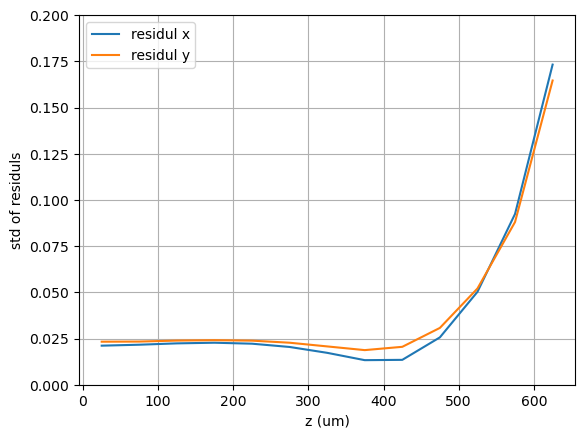

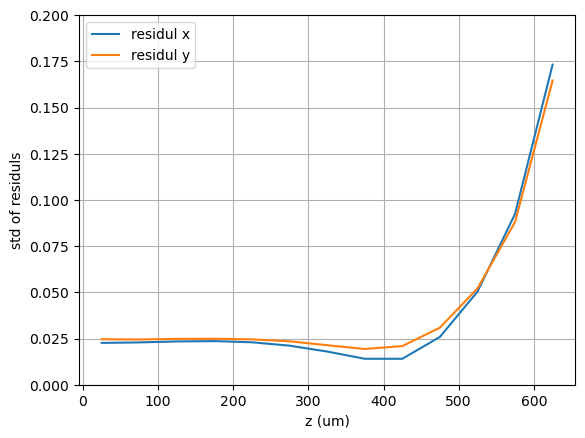

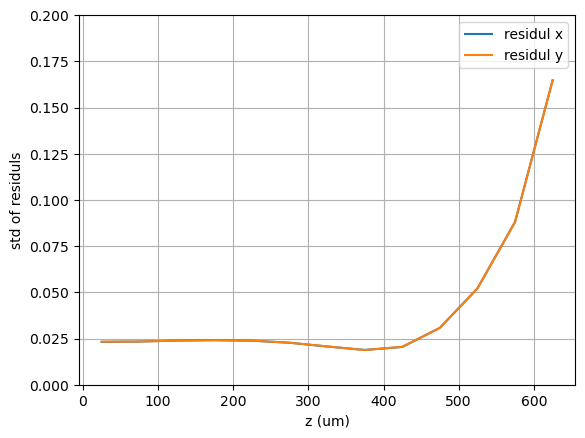

In [16]:
plot_residual_in_depth(residuals_rosenblatt_x, residuals_rosenblatt_y)
plot_residual_in_depth(residuals_rosenblatt_cross_x, residuals_rosenblatt_cross_y)
plot_residual_in_depth(residuals_eta3_x, residuals_eta3_y)
#plot_residual_in_depth(residuals_eta2_x, residuals_eta2_y, residuals_eta2)

['/mnt/sls_det_storage/moench_data/MLXID/Samples/Simulation/Moench040/15keV_Moench040_150V_10.npz', '/mnt/sls_det_storage/moench_data/MLXID/Samples/Simulation/Moench040/15keV_Moench040_150V_4.npz', '/mnt/sls_det_storage/moench_data/MLXID/Samples/Simulation/Moench040/15keV_Moench040_150V_3.npz', '/mnt/sls_det_storage/moench_data/MLXID/Samples/Simulation/Moench040/15keV_Moench040_150V_11.npz', '/mnt/sls_det_storage/moench_data/MLXID/Samples/Simulation/Moench040/15keV_Moench040_150V_2.npz', '/mnt/sls_det_storage/moench_data/MLXID/Samples/Simulation/Moench040/15keV_Moench040_150V_5.npz', '/mnt/sls_det_storage/moench_data/MLXID/Samples/Simulation/Moench040/15keV_Moench040_150V_8.npz', '/mnt/sls_det_storage/moench_data/MLXID/Samples/Simulation/Moench040/15keV_Moench040_150V_6.npz', '/mnt/sls_det_storage/moench_data/MLXID/Samples/Simulation/Moench040/15keV_Moench040_150V_1.npz', '/mnt/sls_det_storage/moench_data/MLXID/Samples/Simulation/Moench040/15keV_Moench040_150V_15.npz', '/mnt/sls_det_st

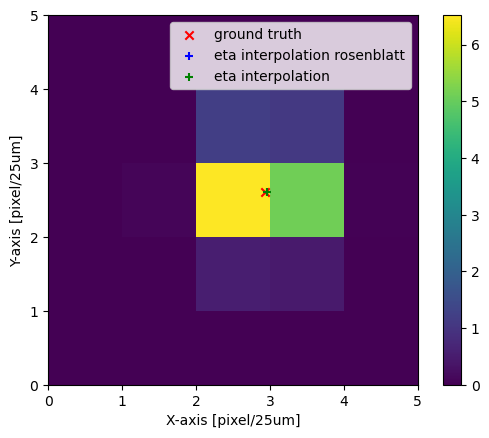

interpolated: (2.9557, 2.6018)
interpolated: (2.9552, 2.6040)


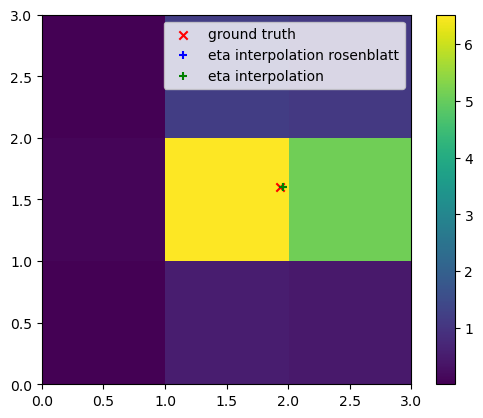

In [18]:
### plot one sample
sampleFileList = glob('/mnt/sls_det_storage/moench_data/MLXID/Samples/Simulation/Moench040/15keV_Moench040_150V_*.npz')
print(sampleFileList)
idx = 15
sample = np.load(sampleFileList[0])['samples'][idx]
labels = np.load(sampleFileList[0])['labels'][idx]
label_x, label_y = labels[0], labels[1]
label_z = labels[2]

print(f'ground truth: ({label_x:.4f}, {label_y:.4f}) (pixel), z={label_z:.4f} (um)') # hwy -2?

### x and y title
plt.xlabel('X-axis [pixel/25um]')
plt.ylabel('Y-axis [pixel/25um]')
### tick labels from 0 to 3
#plt.xticks(np.arange(0, 5, 1))
#plt.yticks(np.arange(0, 5, 1))
plt.scatter([label_x], [label_y], color='red', marker='x', label='ground truth') 
print(f'interpolated: ({interp_photons_rosenblatt[idx]["x"]+1:.4f}, {interp_photons_rosenblatt[idx]["y"]+1:.4f})')
print(f'interpolated: ({interp_photons_non_rosenblatt[idx]["x"]+1:.4f}, {interp_photons_non_rosenblatt[idx]["y"]+1:.4f})')
#print(f'interpolated: ({interp_photons_rosenblatt_cross[idx]["x"]+1:.4f}, {interp_photons_rosenblatt_cross[idx]["y"]+1:.4f})')
plt.scatter([interp_photons_rosenblatt[idx]["x"]+1], [interp_photons_rosenblatt[idx]["y"]+1], color='blue', marker='+', label='eta interpolation rosenblatt')
plt.scatter([interp_photons_non_rosenblatt[idx]["x"]+1], [interp_photons_non_rosenblatt[idx]["y"]+1], color='green', marker='+', label='eta interpolation')
#plt.scatter([interp_photons_rosenblatt_cross[idx]["x"]+1], [interp_photons_rosenblatt_cross[idx]["y"]+1], color='blue', marker='+', label='eta interpolation rosenblatt cross')
plt.imshow(sample, origin="lower", extent=(0,sample.shape[1], 0, sample.shape[0]))
plt.colorbar()
plt.legend()
plt.show()

plt.scatter([label_x-1], [label_y-1], color='red', marker='x', label='ground truth') 
print(f'interpolated: ({interp_photons_rosenblatt[idx]["x"]+1:.4f}, {interp_photons_rosenblatt[idx]["y"]+1:.4f})')
#print(f'interpolated: ({interp_photons_rosenblatt_cross[idx]["x"]+1:.4f}, {interp_photons_rosenblatt_cross[idx]["y"]+1:.4f})')
print(f'interpolated: ({interp_photons_non_rosenblatt[idx]["x"]+1:.4f}, {interp_photons_non_rosenblatt[idx]["y"]+1:.4f})')
plt.scatter([interp_photons_rosenblatt[idx]["x"]], [interp_photons_rosenblatt[idx]["y"]], color='blue', marker='+', label='eta interpolation rosenblatt') 
#plt.scatter([interp_photons_rosenblatt_cross[idx]["x"]+1], [interp_photons_rosenblatt_cross[idx]["y"]+1], color='blue', marker='+', label='eta interpolation rosenblatt cross')
plt.scatter([interp_photons_non_rosenblatt[idx]["x"]], [interp_photons_non_rosenblatt[idx]["y"]], color='green', marker='+', label='eta interpolation')
plt.imshow(sample[1:-1,1:-1], origin="lower", extent=(0,3, 0, 3))
plt.colorbar()
plt.legend()
plt.show()
